## Exploring the Global Streetscapes dataset

Here we familiarize ourselves with the data contained within the [Global Streetscapes](https://ual.sg/project/global-streetscapes/) dataset and introduce some tools and utilities to easily explore it. 

The Global Streetscapes dataset provides context and metadata to millions of crowdsourced images from [Mapillary](https://www.mapillary.com/) and [Kartaview](https://kartaview.org/), covering 688 cities around the world.  The dataset contains more that 300 attributes and has wide geographical, environmental and temporal diversity. 

In [106]:
import geopandas as gpd
import contextily

import ibis
ibis.options.interactive = True

from streetscapes.sources import SourceType
from streetscapes.streetview import SVWorkspace

First, we can create a workspace and add Global Streetscapes as a data source. 
If we show the contents of the data source, we can see the structure of the global streetscapes repository and files that we have already downloaded.

In [107]:
ws = SVWorkspace("../tutorial/Amsterdam", create=True)

gss = ws.add_source(SourceType.GlobalStreetscapes)
gss.show_contents()

datasets--NUS-UAL--global-streetscapes/
├─info.csv
├─data/
│ └─parquet/
│   ├─segmentation.parquet
│   ├─streetscapes.parquet
│   ├─climate.parquet
│   └─perception.parquet
└─.cache/
  └─huggingface/
    ├─.gitignore
    └─download/
      ├─info.csv.lock
      ├─info.csv.metadata
      ├─climate.csv.lock
      └─data/
        └─parquet/
          ├─streetscapes.parquet.metadata
          ├─climate.parquet.lock
          ├─segmentation.parquet.metadata
          ├─segmentation.parquet.lock
          ├─perception.parquet.lock
          ├─climate.parquet.metadata
          ├─streetscapes.parquet.lock
          └─perception.parquet.metadata


Let's load the `info.csv`, which contains the information on all of the different files and their corresponding metadata and attributes of the Global Streetscapes dataset. 

In [108]:
info = gss.load_csv("info", gss.root_dir)
info

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column0 ┃ Filename       ┃ Overview                                                                ┃ Notes                                                                            ┃ Field              ┃ Format ┃ Explanation                                                                      ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64   │ string         │ string                                                                  │ string                                                                           │ string             │ string │ string                                                                           │
├─────────┼────────────────┼─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┤
│       1 │ climate.csv    │ Contains the Koppen climate zone associated with each image's location. │ The calculation is as accurate as the location of the image given by the source… │ uuid               │ string │ Universally Unique IDentifier, unique for every image                            │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView                               │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ koppen_geiger_zone │ string │ A zone code to identify the Koppen climate zone                                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ zone_description   │ string │ Short description of the climate zone                                            │
│       2 │ contextual.csv │ Contains the eight contextual attributes inferred for each image.       │ Please refer to Table 3 in the paper for information on accuracy.                │ uuid               │ string │ Universally Unique IDentifier, unique for every image                            │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView                               │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL      

If we want to look at all of the different files available and what they contain, we can do the following:

In [109]:
filenames = info.to_pandas()
filenames = filenames[~filenames["Filename"].isnull()]
filenames.head()

,column0,Filename,Overview,Notes,Field,Format,Explanation
0,1.0,climate.csv,Contains the Koppen climate zone associated wi...,The calculation is as accurate as the location...,uuid,string,"Universally Unique IDentifier, unique for ever..."
5,2.0,contextual.csv,Contains the eight contextual attributes infer...,Please refer to Table 3 in the paper for infor...,uuid,string,"Universally Unique IDentifier, unique for ever..."
16,3.0,ephem.csv,Contains the temporal information of each imag...,The accuracy of the calculation is as accurate...,uuid,string,"Universally Unique IDentifier, unique for ever..."
24,4.0,gadm.csv,Contains the administrative area associated wi...,The calculation is as accurate as the location...,uuid,string,"Universally Unique IDentifier, unique for ever..."
65,5.0,ghsl.csv,Contains the degree of urbanisation associated...,The calculation is as accurate as the location...,uuid,string,"Universally Unique IDentifier, unique for ever..."


### Loading the data

We can load the entire `streetscapes.parquet` set from Global Streetscapes with the `load_parquet()` function. This uses [`ibis`](https://ibis-project.org/) in the background, which is able to handle data a lot faster than `pandas` and is therefore useful for handling larger datasets. 

`streetscapes.parquet` combines the following csv files from the original dataset: contextual.csv, metadata_common_attributes.csv, segmentation.csv, simplemaps.csv, ghsl.csv, perception.csv, places365.csv, and osm.csv

In [110]:
# Load streetscapes.parquet dataset
streetscapes = gss.load_parquet("streetscapes")
streetscapes.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id         ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat        ┃ lon        ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence    ┃ Guard-Rail ┃ Barrier ┃ Wall    ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road         ┃ Service-Lane ┃ Sidewalk ┃ Bridge   ┃ Building ┃ Tunnel  ┃ Person  ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky          ┃ Snow    ┃ Terrain  ┃ Vegetation   ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat    ┃ Bus     ┃ Car     ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city          ┃ city_ascii    ┃ city_id    ┃ city_lat ┃ city_lon ┃ country        ┃ iso2   ┃ iso3   ┃ admin_name             ┃ capital ┃ population   ┃ continent     ┃ urban_code ┃ urban_term             ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place                    ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid                          ┃ oneway  ┃ lanes  ┃ name                      ┃ highway   ┃ type_highway ┃ maxspeed ┃ junction ┃ length   ┃ from         ┃ to           ┃ ref         ┃ tunnel_1 ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━

If you need data from other files, or only data from one file, then individual parquet files are also available.

Let's load `perception.parquet`, which is included in streetscapes.parquet, as an example:

In [111]:
perception = gss.load_parquet("perception")
perception

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id      ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string                               │ string    │ float64      │ float64   │ float64 │ float64    │ float64 │ float64 │ float64 │
├──────────────────────────────────────┼───────────┼──────────────┼───────────┼─────────┼────────────┼─────────┼─────────┼─────────┤
│ 12039441-fd9e-4ca9-bc0f-957b713e12f1 │ KartaView │ 5.658903e+08 │      1.32 │    2.03 │       2.21 │    5.87 │    0.38 │    5.29 │
│ 05a2f4e8-4a15-4c69-afcc-b411c4b995e5 │ KartaView │ 5.658903e+08 │      4.23 │    1.82 │       1.38 │    2.70 │    0.76 │    4.52 │
│ 5292f74f-a519-4536-828b-f19de21f0df3 │ KartaView │ 5.658903e+08 │      1.67 │    3.52 │       0.84 │    3.39 │    1.00 │    2.57 │
│ 1593f561-d6cd-4936-88d7-3675efc9421e │ KartaView │ 5.658903e+08 │      1.97 │    2.71 │       3.42 │    4.61 │    1.67 │    3.95 │
│ 4a05386c-cd98-42fc-9e3c-f361f32a8ed7 │ KartaView │ 5.658903e+08 │      6.43 │    1.14 │       1.72 │    4.48 │    0.55 │    2.29 │
│ 57294d2f-13a9-40e1-b13e-0a809d131e6d │ KartaView │ 5.658906e+08 │      2.44 │    0.83 │       4.45 │    6.64 │    1.07 │    4.88 │
│ 2010ce23-3254-4b19-8b81-b9f614ec7932 │ KartaView │ 5.658904e+08 │      2.85 │    0.93 │       1.82 │    6.51 │    0.54 │    3.92 │
│ 5c00ea5b-1487-4499-b1a7-da1a348c550c │ KartaView │ 5.658903e+08 │      1.62 │    0.92 │       1.68 │    2.98 │    0.82 │    2.60 │
│ fca19492-6132-4790-8d57-0a3f0f42cc98 │ KartaView │ 5.696926e+08 │      2.42 │    2.47 │       4.22 │    5.00 │    2.33 │    0.37 │
│ 6c51acf6-5681-40c4-b00b-781bcf6be54d │ KartaView │ 5.658905e+08 │      1.60 │    3.77 │       1.94 │    4.71 │    0.66 │    2.10 │
│ …                                    │ …         │            … │         … │       … │          … │       … │       … │       … │
└──────────────────────────────────────┴───────────┴──────────────┴───────────┴─────────┴────────────┴─────────┴─────────┴─────────┘

In [112]:
perception.columns

('uuid',
 'source',
 'orig_id',
 'Beautiful',
 'Boring',
 'Depressing',
 'Lively',
 'Safe',
 'Wealthy')

### Explore the data

Now, prepare a subset of Global Streetscapes by selecting entries for the city of Amsterdam. The subset name is composed of a path relative to the root directory of the workspace (`subsets`) and the file name (`amsterdam`). By default, subsets are saved as `parquet` files, so we don't have to specify the extension. Here, we specify that we would like to recreate the subset at every run of the notebook (`recreate=True`), as well as that we would like to save the file.

In [113]:
# Subset name (path relative to the root directory of the workspace + file name without the .parquet extension)
subset = "subsets/amsterdam"

# Criteria used to filter the large Global Streetscapes dataset.
criteria = {"city": "Amsterdam"}

# Create the subset and assign it to a variable that we can use below.
# The method also returns the path to the saved subset if the dataset was saved to disk (triggered by save=True).
(ams, ams_path) = ws.load_dataset(gss, subset, criteria=criteria, recreate=True, save=True)

Dataset subsets/amsterdam | Done: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]     


Check the path to the saved subset file. It should be a path relative to the root directory of the workspace and the first few lines of the subset:

In [114]:
print(ams_path)
print(ams.head())

/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorial/Amsterdam/subsets/amsterdam.parquet


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━
┃ uuid                                 ┃ source    ┃ orig_id          ┃ glare   ┃ lighting_condition ┃ pano_status 
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━
│ string                               │ string    │ int64            │ boolean │ string             │ boolean     
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼────────────────────┼─────────────
│ 840d52d5-1bbe-4f77-ac5a-5d8905dca06e │ Mapillary │ 2585835221712723 │ False   │ day                │ True        
│ 6a81f09d-24b9-4179-8eb5-9cd2e91c13d9 │ Mapillary │ 4130433687048823 │ False   │ day                │ False       
│ 26c37fae-3485-4ca1-8b97-9f449a8da680 │ Mapillary │  219442182852752 │ False   │ day                │ False       
│ b8ae9b6a-deb3-4e85-a6e9-75c03f77573e │ Mapillary │ 4077211285668521 │ 

...and the total number of rows.

In [115]:
ams.count()

┌───────┐
│ 25950 │
└───────┘

#### Perception Example

We can subset the dataset further by selecting columns we want to keep and specifying criteria, such as time of day the image was taken or the viewing angle. Here we take images taken during the day on a walking surface and keep columns related to perception.

In [150]:
subset = 'Amsterdam_walk'
criteria = {"city": "Amsterdam", "lighting_condition": "day", "platform": "walking surface"}
columns = {'uuid', 'source', 'lat', 'lon', "orig_id", "Beautiful", "Depressing", "Safe"}

(ams_walk, ams_walk_path) = ws.load_dataset(gss, subset, criteria=criteria, columns=columns, recreate=True)

subset = 'Amsterdam_drive'
criteria = {"city": "Amsterdam", "lighting_condition": "day", "platform": "driving surface"}
(ams_drive, ams_drive_path) = ws.load_dataset(gss, subset, criteria=criteria, columns=columns, recreate=True)

Dataset Amsterdam_walk | Done: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]     
Dataset Amsterdam_drive | Done: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]     


In [151]:
ams_drive.columns

('uuid', 'orig_id', 'source', 'Beautiful', 'lon', 'Safe', 'lat', 'Depressing')

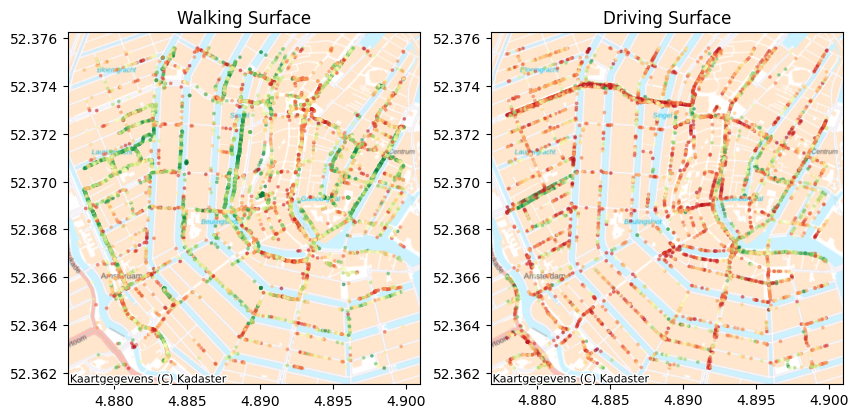

In [157]:
import matplotlib.pyplot as plt

def convert_to_gdf(table):
    df = table.to_pandas()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    return gdf

gdf_walk = convert_to_gdf(ams_walk)
gdf_drive = convert_to_gdf(ams_drive)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
ax = gdf_walk.plot(column='Safe', ax=ax1, cmap='RdYlGn', markersize=3, alpha=0.5)
contextily.add_basemap(ax, crs=gdf_walk.crs, source=contextily.providers.nlmaps.pastel)
ax1.set_title('Walking Surface')

# Plot the raster on the second subplot
ax = gdf_drive.plot(column='Safe', ax=ax2, cmap='RdYlGn', markersize=3, alpha=0.5)
contextily.add_basemap(ax, crs=gdf_drive.crs, source=contextily.providers.nlmaps.pastel)
ax2.set_title('Driving Surface')

# Show the plot
plt.show()

#### Building Fraction Example

We can take this idea further and create new columns for aspects we are interested in and filter the data. For example, we can calculate the building fraction of each image and filter for images where more than 15% of the pixels are buildings. 

In [128]:
# Calculate building fraction and create new column
building_fraction = ams["Building"] / ams["Total"]
ams = ams.mutate(building_fraction=building_fraction)

# Filter for buildings
ams_buildings = ams.filter(ams["building_fraction"] > 0.15)
ams_buildings.head(5)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id          ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat       ┃ lon      ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence   ┃ Guard-Rail ┃ Barrier ┃ Wall     ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road     ┃ Service-Lane ┃ Sidewalk ┃ Bridge  ┃ Building     ┃ Tunnel  ┃ Person   ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky      ┃ Snow    ┃ Terrain ┃ Vegetation ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat     ┃ Bus     ┃ Car     ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city      ┃ city_ascii ┃ city_id    ┃ city_lat ┃ city_lon ┃ country     ┃ iso2   ┃ iso3   ┃ admin_name    ┃ capital ┃ population ┃ continent ┃ urban_code ┃ urban_term   ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place     ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid     ┃ oneway  ┃ lanes  ┃ name                    ┃ highway      ┃ type_highway ┃ maxspeed ┃ junction ┃ length  ┃ from         ┃ to           ┃ ref    ┃ tunnel_1         ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃ building_fraction ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━

In [129]:
ams_buildings.count()

┌───────┐
│ 21591 │
└───────┘

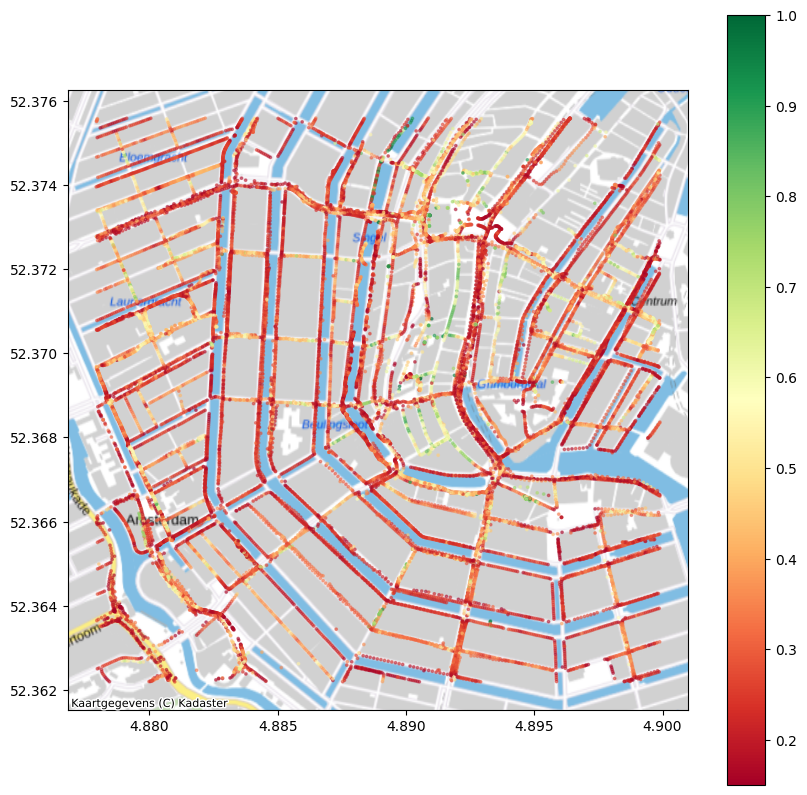

In [131]:
df = ams_buildings.to_pandas()
gdf = gpd.GeoDataFrame(df.building_fraction, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
ax = gdf.plot(column='building_fraction', cmap='RdYlGn', legend=True, markersize=3, figsize=(10, 10), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)

### Download Images

Next, we will download images for the Amsterdam subset that we created above by using the images sources that we loaded into our workspace. We can download all the images corresponding to a data source in one go. However, the unified API of all image sources requires that the dataset contain two hardwired columns: `source` and `image_id`. This is a design choice to avoid having to handle potentially very different sources. Ibis makes it trivial to remap column names with the `select` method by providing a dictionary with the desired column names as keys and the existing columns that they map to as values.

In [120]:
src_table = ams.select({"source": "source", "image_id": "orig_id"})

Extract the source types in the table. A source must be supported ***and*** loaded in order to be recognised.

In [121]:
source_types = ws.get_source_types_from_table(src_table)
source_types

{<SourceType.KartaView: 'kartaview'>, <SourceType.Mapillary: 'mapillary'>}

In [122]:
mp = ws.add_source(SourceType.Mapillary)
kv = ws.add_source(SourceType.KartaView)

Now we are ready to instruct the workspace manager to download the images. We can request only a sample of all the images (useful for initial prototyping and demonstrations like this one). Only missing images will be downloaded.

In [123]:
sample = ws.download_images(src_table, sample=10)

Streetscapes | 2025-05-01@11:47:33 | Reusing an existing Mapillary source, use the replace argument to override.


Peek into the sample.

In [124]:
sample

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ source    ┃ image_id         ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ string    │ int64            │
├───────────┼──────────────────┤
│ Mapillary │  234940958429967 │
│ Mapillary │  610299716593061 │
│ Mapillary │  204650847905762 │
│ Mapillary │  371786764260356 │
│ Mapillary │ 2867973510144653 │
│ Mapillary │  972620480144114 │
│ Mapillary │  173303714684085 │
│ Mapillary │  504401394083376 │
│ Mapillary │ 2559967550978215 │
│ Mapillary │  135803585261117 │
└───────────┴──────────────────┘

Some of the images that we request might not exist any more on the image source. Figure out which images have been downloaded and which ones are missing.

In [125]:
existing, missing = ws.check_image_status(sample)
print(f"==[ existing: {[i.name for e in existing.values() for i in e]}")
print(f"==[ missing: {missing}")

Streetscapes | 2025-05-01@11:47:35 | Reusing an existing Mapillary source, use the replace argument to override.


==[ existing: ['972620480144114.jpeg', '504401394083376.jpeg', '204650847905762.jpeg', '173303714684085.jpeg', '610299716593061.jpeg']
==[ missing: {<SourceType.Mapillary: 'mapillary'>: {'2867973510144653', '371786764260356', '2559967550978215', '135803585261117', '234940958429967'}}
